In [1]:
import src.generation.gamma as ga
import src.generation.multivariate_normal as mn

from src.salp.salp import SALP
from src.salp.salp import Node

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# funkcja do produkowania wykresów obciążenia węzłów

def plot_node_load(n: Node, estimated_node_load: float = None, actual_mean_node_load: float = None, node_power: float = None):
    size = n.ws.size
    plt.bar(
        np.arange(size),
        n.ws
    )
    plt.title("Node {}".format(n.identity))
    if estimated_node_load:
        plt.hlines(estimated_node_load, xmin=0-1, xmax=size, colors='r')
    if actual_mean_node_load:
        plt.hlines(actual_mean_node_load, xmin=0-1, xmax=size, colors='g', linestyle='dashed')
    if node_power:
        plt.hlines(node_power, xmin=0-1, xmax=size, colors='orange')
    plt.show()

In [21]:
from typing import List

def calculate_total_node_queueing_time(n: Node, power: float) -> float:
    stb = np.mean(n.ws)/power
    assert stb < 1, "Node {} is not stable".format(n.identity)
    coeff = stb/(1-stb)
    return coeff * np.sum(n.ws)
    
def calculate_all_nodes_queueing_time(nodes: List[Node], power: float) -> float:
    total_ct = 0
    for n in nodes:
        ct = calculate_total_node_queueing_time(n, node_power)
        total_ct += ct
    return total_ct

In [25]:
# TODO algorithms
# SALP
def salp_wrapper(N: int, load_vectors):
    return SALP(N, load_vectors, False)
# Best Fit
def bf_wrapper(N: int, load_vectors):
    return None
# Round robin
def rr_wrapper(N: int, load_vectors):
    return None

algorithms = [
    ('SALP', salp_wrapper),
    ('BF', bf_wrapper),
    ('RR', rr_wrapper),
]

## Example pipeline

Estimated minimal node power 30.0
Node power 37.5
Actual mean node load 30.535181639892073
-----------------------
Node 0: 0.8347561211003477 1581.3394715916868


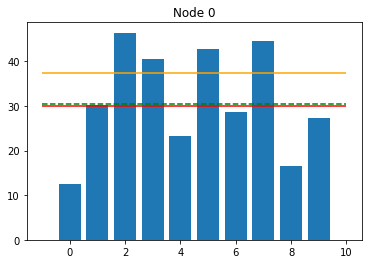

Node 1: 0.831447130463926 1538.0285411176492


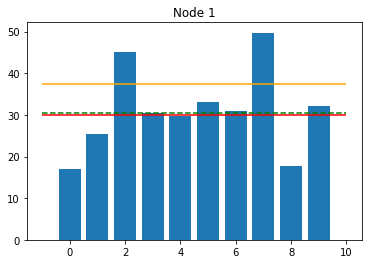

Node 2: 0.791056337179156 1123.0960300669558


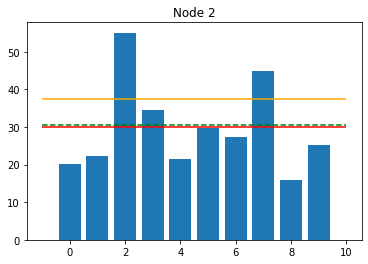

Node 3: 0.799826452845058 1198.439486191584


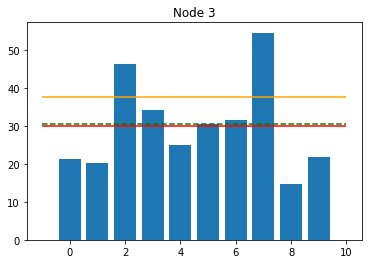

In [16]:
def pipeline(F: int, N: int, size: int, cor: float, ro: float, rng = (2,4)):
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated minimal node power", estimated_node_load)
    
    node_power = estimated_node_load/ro
    print("Node power", node_power)
    
    load_vectors = generator.generate_cloud_load_vectors()
    actual_mean_node_load = np.sum(load_vectors)/size/N
    print("Actual mean node load", actual_mean_node_load)
    
    cloud = SALP(N, load_vectors, False)
    assert len(cloud.nodes) == N
    
    print('-----------------------')
    
    for n in cloud.nodes:
        ct = calculate_total_node_queueing_time(n, node_power)
        print("Node {}:".format(n.identity), np.mean(n.ws)/node_power, ct)
        plot_node_load(n,estimated_node_load,actual_mean_node_load, node_power)
    
    
pipeline(20, 4, 10, 0.5, 0.8)

### Walidacja SALP

----------------DESCRIPTION----------------
Shards:
[[3 1]
 [3 1]
 [3 1]
 [1 3]
 [1 3]
 [1 3]]

WTS:
[12 12]

NWTS:
[6. 6.]

LW:
[(0, 3.1622776601683795), (1, 3.1622776601683795), (2, 3.1622776601683795), (3, 3.1622776601683795), (4, 3.1622776601683795), (5, 3.1622776601683795)]


----------------ASSIGNMENT----------------
Shard ID: 0
Shard: [3 1]

	Node ID: 0
	Delta: 2.654329479393269

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 1
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 2
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 1.8309518948453007

Shard ID: 3
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 3.0025247700991105

Shard ID: 4
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 1.4142135623730951

Shard ID: 5
Shard: [1 3]

	Node ID: 1
	Delta: 1.4142135623730951

----------------FINAL NODES----------------
Node: 0
	Shards assigned [FS]: [0 2 4]
	

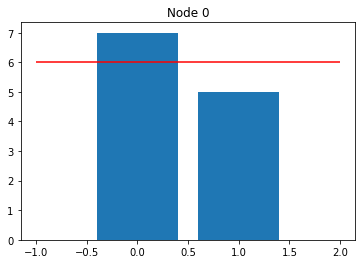

Node 1: 1.0


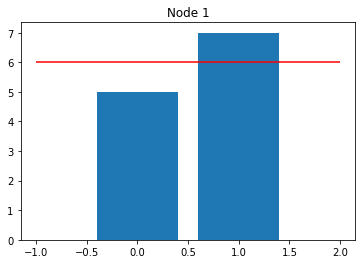

In [7]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = SALP(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

# Parametry dla iteracji
* F - ilość shardów
* N - ilość węzłów
* cor - poziom korelacji miedzy wektorami obciążenia
* ro - poziom obciążenia chmury
* size - długość wektorów obciążenia
* repeats - ilość powtórzeń pojedynczej symulacji
* parametry generatora do ustalenia

In [23]:
N = 100
F = 10*N
cor_range = np.arange(0.0, 1.01, 0.25)
load_range = [0.8, 0.9]
size=100
repeats=10
rng = (2,4)

In [24]:
for cor in cor_range:
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated node load", estimated_node_load)
    
    for ro in load_range:
        
        node_power = estimated_node_load/ro
        
        for _ in range(repeats):
            
            load_vectors = generator.generate_cloud_load_vectors()
#             actual_mean_node_load = np.sum(load_vectors)/size/N
#             print("Actual mean node load", actual_mean_node_load)
            
            # TODO test all algorithms here
            cloud = SALP(N, load_vectors, False)
            total_ct = calculate_all_nodes_queueing_time(cloud.nodes, node_power)
            
            print(cor, ro, total_ct)

Estimated node load 60.0
0.0 0.8 2398786.606168348
0.0 0.8 2389870.876937694
0.0 0.8 2419769.9188923766
0.0 0.8 2384611.146447257
0.0 0.8 2417663.304331718
0.0 0.8 2393911.6205881895
0.0 0.8 2372802.184590991
0.0 0.8 2381484.229750675
0.0 0.8 2413379.674832566
0.0 0.8 2370857.3124085832
0.0 0.9 5312246.192959625
0.0 0.9 5445588.062547205
0.0 0.9 5271743.667277945
0.0 0.9 5513644.079870501
0.0 0.9 5386713.39784813
0.0 0.9 5473338.193618908
0.0 0.9 5521138.445867323
0.0 0.9 5531564.088319614
0.0 0.9 5294436.086705284
0.0 0.9 5484346.895773158
Estimated node load 60.0
0.25 0.8 2575803.771763748
0.25 0.8 2483336.954561061
0.25 0.8 2489722.433728414
0.25 0.8 2492403.0863519795
0.25 0.8 2481307.9609455164
0.25 0.8 2516844.634250069
0.25 0.8 2516080.0236226455
0.25 0.8 2486643.2715104646
0.25 0.8 2511671.1192297325
0.25 0.8 2475976.1526179686
0.25 0.9 5969282.372656699
0.25 0.9 5949449.794944798
0.25 0.9 5773560.285009433
0.25 0.9 5889838.195345275
0.25 0.9 5850203.799410118
0.25 0.9 5951906.